# MVP and HRP Portfolio Design for Auto Sector Stocks


<a id='1'></a>
## 1. Loading the Data and Python Libraries

<a id='1.1'></a>
### 1.1. Loading the Python Libraries

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from datetime import date

#Import Model Packages 
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold

#Package for optimization of mean variance optimization
import cvxopt as opt
from cvxopt import blas, solvers


<a id='1.2'></a>
### 1.2. Loading the Data

In [2]:
# load dataset
dataset = read_csv('psu_banks.csv',index_col=0)

In [3]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
type(dataset)

pandas.core.frame.DataFrame

<a id='2'></a>
## 2. Exploratory Data Analysis

In [5]:
# shape
dataset.shape

(1482, 10)

In [6]:
# peek at data
set_option('display.width', 100)
dataset.head()

SBIN  BANKBARODA       CANBK         PNB   UNIONBANK   BANKINDIA     INDIANB  \
date                                                                                             
01-01-2016  227.800003  159.050003  231.783630  117.599998  150.000000  117.349998  114.849998   
04-01-2016  220.699997  151.199997  226.968994  112.800003  144.649994  114.699997  113.199997   
05-01-2016  217.750000  148.100006  224.294189  110.599998  142.949997  113.900002  112.500000   
06-01-2016  216.850006  148.699997  221.278961  109.599998  143.649994  114.250000  110.699997   
07-01-2016  209.550003  139.500000  212.719605  105.050003  135.550003  109.050003  107.900002   

                  IOB  CENTRALBK   MAHABANK  
date                                         
01-01-2016  31.350000  71.800003  32.250000  
04-01-2016  30.650000  70.000000  31.700001  
05-01-2016  30.900000  69.449997  32.049999  
06-01-2016  30.700001  69.099998  31.850000  
07-01-2016  29.500000  67.849998  31.150000

<a id='3'></a>
## 3. Data Pre-processing

<a id='3.1'></a>
### 3.1. Data Cleaning
We check for the NAs in the rows, either drop them or fill them with the mean of the column.

In [7]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())
dataset.shape

Null Values = False


(1482, 10)

Getting rid of the columns with more than 30% missing values. 

In [8]:
missing_fractions = dataset.isnull().mean().sort_values(ascending=False)

missing_fractions.head(10)

drop_list = sorted(list(missing_fractions[missing_fractions > 0.4].index))

dataset.drop(labels=drop_list, axis=1, inplace=True)
dataset.shape

(1482, 10)

Given that there are null values drop the rown contianing the null values.

In [9]:
# Fill the missing values with the last value available in the dataset. 
dataset=dataset.fillna(method='ffill')
dataset.head()

SBIN  BANKBARODA       CANBK         PNB   UNIONBANK   BANKINDIA     INDIANB  \
date                                                                                             
01-01-2016  227.800003  159.050003  231.783630  117.599998  150.000000  117.349998  114.849998   
04-01-2016  220.699997  151.199997  226.968994  112.800003  144.649994  114.699997  113.199997   
05-01-2016  217.750000  148.100006  224.294189  110.599998  142.949997  113.900002  112.500000   
06-01-2016  216.850006  148.699997  221.278961  109.599998  143.649994  114.250000  110.699997   
07-01-2016  209.550003  139.500000  212.719605  105.050003  135.550003  109.050003  107.900002   

                  IOB  CENTRALBK   MAHABANK  
date                                         
01-01-2016  31.350000  71.800003  32.250000  
04-01-2016  30.650000  70.000000  31.700001  
05-01-2016  30.900000  69.449997  32.049999  
06-01-2016  30.700001  69.099998  31.850000  
07-01-2016  29.500000  67.849998  31.150000

<a id='3.2'></a>
### 3.2. Training and Test Dataset Preparation

For the purpose of clustering, we will be using annual return figures. Let us prepare the dataset for training and testing, by separating 83.35% of the records for training the models and remaining records for testing. These figures have been chosen in such a way that the records of the year 2021 go into the test dataset while other records remain in the training dataset.

In [14]:
X= dataset.copy('deep')
row= len(X)
train_len = int(row*.8330)

In [15]:
X_train = X.head(train_len)

In [16]:
X_train

SBIN  BANKBARODA       CANBK         PNB   UNIONBANK   BANKINDIA     INDIANB  \
date                                                                                             
01-01-2016  227.800003  159.050003  231.783630  117.599998  150.000000  117.349998  114.849998   
04-01-2016  220.699997  151.199997  226.968994  112.800003  144.649994  114.699997  113.199997   
05-01-2016  217.750000  148.100006  224.294189  110.599998  142.949997  113.900002  112.500000   
06-01-2016  216.850006  148.699997  221.278961  109.599998  143.649994  114.250000  110.699997   
07-01-2016  209.550003  139.500000  212.719605  105.050003  135.550003  109.050003  107.900002   
...                ...         ...         ...         ...         ...         ...         ...   
24-12-2020  266.850006   60.849998  120.750000   31.450001   29.900000   48.900002   86.400002   
28-12-2020  275.200012   62.400002  125.250000   32.400002   30.500000   49.400002   88.449997   
29-12-2020  277.899994   62.349998  126.349998   33.200001   31.900000   49.400002   88.300003   
30-12-2020  276.899994   62.099998  129.350006   32.750000   31.950001   49.200001   87.050003   
31-12-2020  274.950012   61.450001  128.949997   33.049999   31.549999   48.700001   85.699997   

                  IOB  CENTRALBK   MAHABANK  
date                                         
01-01-2016  31.350000  71.800003  32.250000  
04-01-2016  30.650000  70.000000  31.700001  
05-01-2016  30.900000  69.449997  32.049999  
06-01-2016  30.700001  69.099998  31.850000  
07-01-2016  29.500000  67.849998  31.150000  
...               ...        ...        ...  
24-12-2020  10.600000  13.850000  13.250000  
28-12-2020  10.700000  14.050000  13.300000  
29-12-2020  10.600000  13.900000  13.150000  
30-12-2020  10.500000  13.750000  13.050000  
31-12-2020  10.700000  13.850000  13.050000  

[1234 rows x 10 columns]

In [17]:
X_test = X.tail(row-train_len)

In [18]:
#Calculate percentage return 
returns = X_train.pct_change().dropna()
returns_test=X_test.pct_change().dropna()

The parameters to clusters are the indices and the variables used in the clustering are the columns. Hence the data is in the right format to be fed to the clustering algorithms.

<a id='4'></a>
## 4. Evaluate the Models

<a id='4.1'></a>
### 4.1. Building Dendrogram for the HRP Model

The first step is to look for clusters of correlated stcoks using the agglomerate hierarchical clustering technique. The hierarchy class
has a dendrogram method which takes the value returned by the linkage method of
the same class.

Linkage does the actual clustering in one line of code, and returns a list of the clusters joined in the format: Z=[stock_1, stock_2, distance, sample_count]

#### Correlation Computation

In [19]:
def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist = ((1 - corr) / 2.)**.5  # distance matrix
    return dist

In [20]:
#Calulate linkage
dist = correlDist(returns.corr())
link = linkage(dist, 'ward')
link[0]

array([2.       , 4.       , 0.4610859, 2.       ])

Computation of linkages is followed by the visualization of the clusters through a dendrogram, which displays a cluster tree.
The leaves are the individual stocks and the root represents the final single cluster. The “distance” between each cluster is shown along the y-axis, and thus the longer the branches indicate less correlated clusters of stcoks.

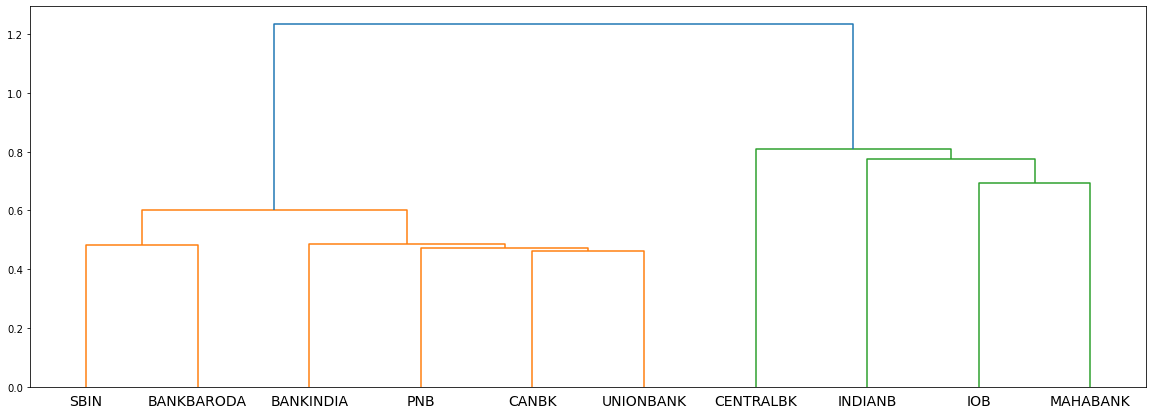

In [21]:
#Plot Dendogram
plt.figure(figsize=(20, 7))
#plt.title("Dendrograms")
dendrogram(link,labels = X.columns, leaf_font_size=14)
plt.show()

<a id='4.2'></a>
### 4.2 Steps involved in the HRP Model Design 

#### Quasi-Diagonalization and Weights Computation for HRP


Quasi-diagonalization is a matrix seriation process used in hierarchical clustering. The process involves reorganizing the covariance matrix of returns in such a way that stocks with similar returns are placed together. This matrix diagonalization allows us to distribute weights optimally following an inverse-variance allocation. For more details refer to Chapter 4 of the book.

In [22]:
def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx.append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()

#### Recursive Bisection

This step distributes the weights through recursive bisection based on the cluster covariance.

In [23]:
def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar



def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w

#### Comparison of HRP with MVP

So, in this step, python functions are defined for comparing the following two portfolio design approaches.

    1. MVP - Markowitz’s Minimum-Variance Portfolio
    2. HRP - Hierarchial Risk Parity

In [24]:
def getMVP(cov):

    cov = cov.T.values
    n = len(cov)
    N = 100
    mus = [10 ** (5.0 * t / N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(cov)
    #pbar = opt.matrix(np.mean(returns, axis=1))
    pbar = opt.matrix(np.ones(cov.shape[0]))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))  # negative n x n identity matrix
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    
    # Calculate efficient frontier weights using quadratic programming
    solvers.options['show_progress'] = False
    portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)['x']
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER    
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO    
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']

    return list(wt)

def getIVP(cov, **kargs):
    # Compute the inverse-variance portfolio
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

def getHRP(cov, corr):
    # Construct a hierarchical portfolio
    dist = correlDist(corr)
    link = sch.linkage(dist, 'single')
    #plt.figure(figsize=(20, 10))
    #dn = sch.dendrogram(link, labels=cov.index.values)
    #plt.show()
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx)
    return hrp.sort_index()

#### Computation of the Weight Allocation for the Portfolios

In [25]:
def get_all_portfolios(returns):
    
    cov, corr = returns.cov(), returns.corr()
    hrp = getHRP(cov, corr)
    mvp = getMVP(cov)
    mvp = pd.Series(mvp, index=cov.index)
    portfolios = pd.DataFrame([mvp, hrp], index=['MVP', 'HRP']).T
    #portfolios = pd.DataFrame([ivp, hrp], index=['IVP', 'HRP']).T
    return portfolios

In [26]:
portfolios = get_all_portfolios(returns)
print(portfolios)

                 MVP       HRP
SBIN        0.318272  0.146261
BANKBARODA  0.002201  0.115754
CANBK       0.001166  0.051269
PNB         0.001279  0.086509
UNIONBANK   0.001308  0.097070
BANKINDIA   0.001672  0.053928
INDIANB     0.006472  0.101254
IOB         0.319199  0.122128
CENTRALBK   0.157446  0.129415
MAHABANK    0.190986  0.096412


Text(0.5, 1.0, 'HRP')

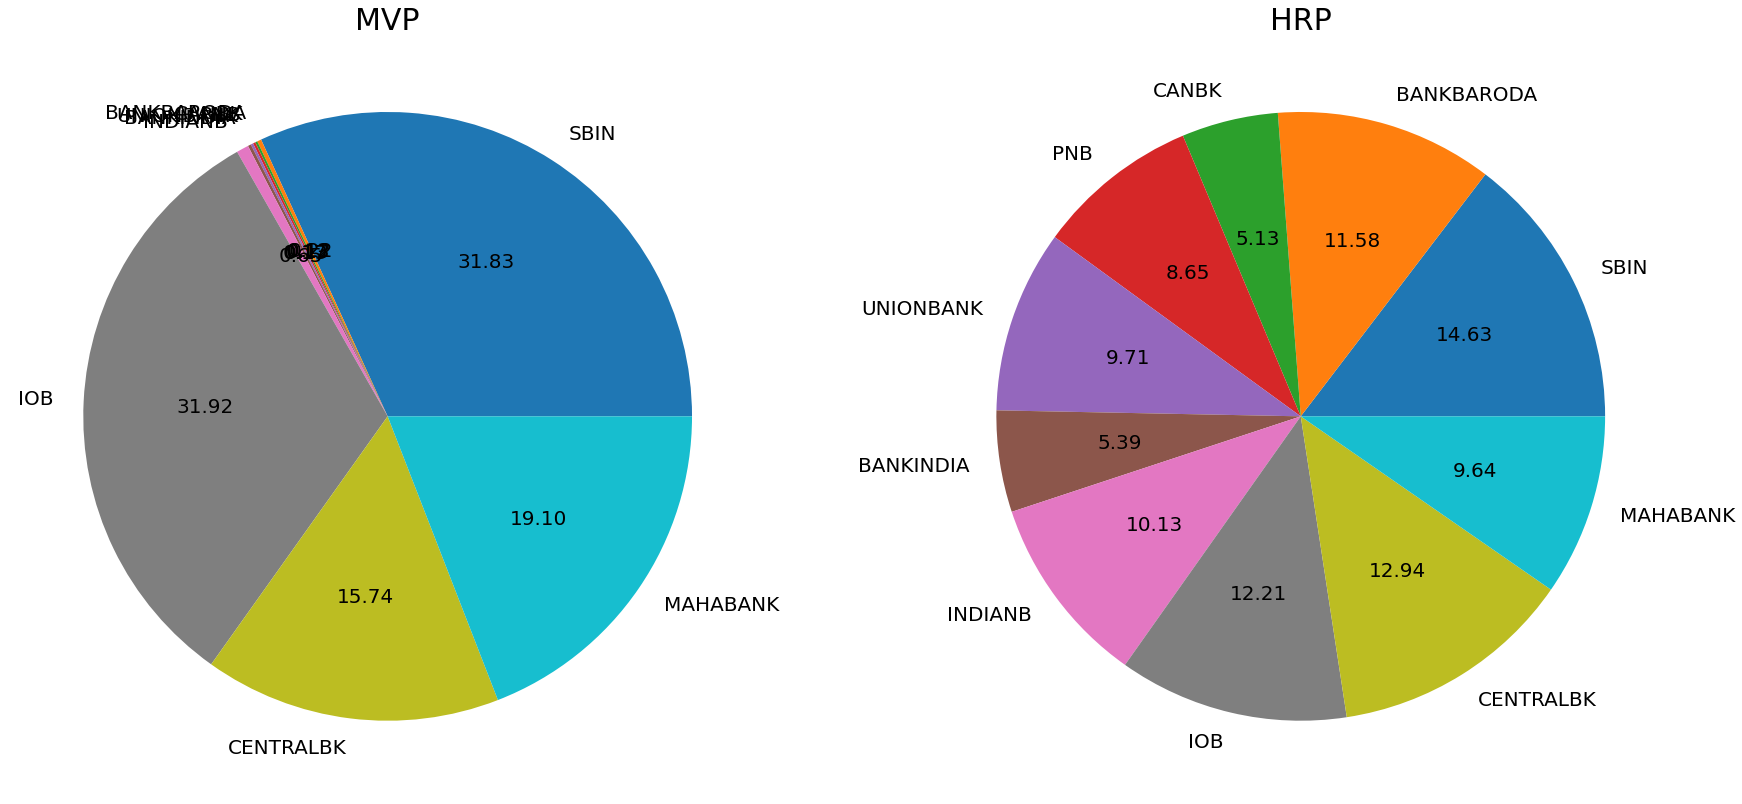

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(30,20))
ax1.pie(portfolios.iloc[:,0], labels= portfolios.index, autopct='%.2f', textprops={'fontsize': 20});
ax1.set_title('MVP',fontsize = 30)
ax2.pie(portfolios.iloc[:,1], labels=portfolios.index, autopct='%.2f', textprops={'fontsize': 20});
ax2.set_title('HRP',fontsize = 30)
#portfolios.plot.pie(subplots=True, figsize=(20, 10),legend = False);

In [28]:
# MVP - Markowitz’s Minimum-Variance Portfolio Weights
portfolios.iloc[:,0]

SBIN          0.318272
BANKBARODA    0.002201
CANBK         0.001166
PNB           0.001279
UNIONBANK     0.001308
BANKINDIA     0.001672
INDIANB       0.006472
IOB           0.319199
CENTRALBK     0.157446
MAHABANK      0.190986
Name: MVP, dtype: float64

In [29]:
# HRP - Hierarchial Risk Parity Portfolio Weights
portfolios.iloc[:,1]

SBIN          0.146261
BANKBARODA    0.115754
CANBK         0.051269
PNB           0.086509
UNIONBANK     0.097070
BANKINDIA     0.053928
INDIANB       0.101254
IOB           0.122128
CENTRALBK     0.129415
MAHABANK      0.096412
Name: HRP, dtype: float64

<a id='5'></a>
## 5. Performance Evaluation of the Portfolios 

### 5.1 Cumulative Returns - Training and Test Data 

In [30]:
Insample_Result=pd.DataFrame(np.dot(returns,np.array(portfolios)), \
                             columns=['MVP', 'HRP'], index = returns.index)
OutOfSample_Result=pd.DataFrame(np.dot(returns_test,np.array(portfolios)), \
                                columns=['MVP', 'HRP'], index = returns_test.index)

<AxesSubplot:xlabel='date', ylabel='Return'>

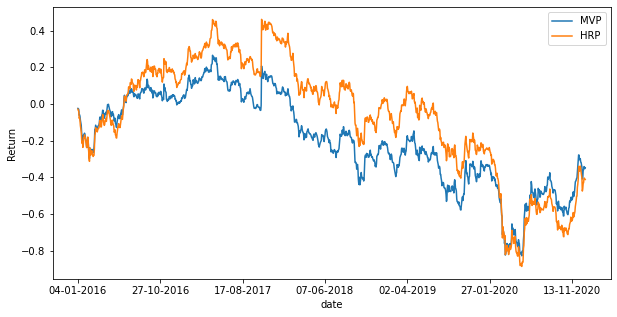

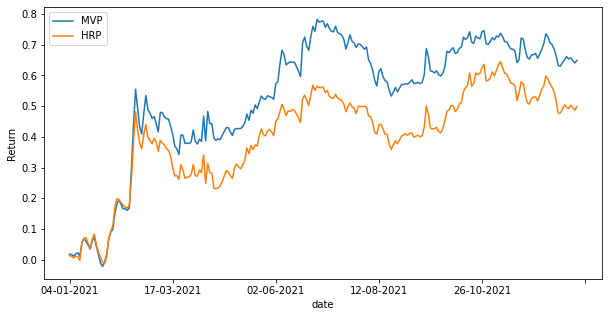

In [31]:
Insample_Result.cumsum().plot(figsize=(10, 5), ylabel = "Return")
OutOfSample_Result.cumsum().plot(figsize=(10, 5), ylabel = "Return")

In [32]:
ret_insample=Insample_Result.mean() * 252
ret_insample

MVP   -0.071178
HRP   -0.084261
dtype: float64

In [33]:
ret_out_of_sample = OutOfSample_Result.mean() * 252
ret_out_of_sample

MVP    0.661179
HRP    0.507833
dtype: float64

###  5.2 Sharpe Ratio and Annual Volatility - Training and Test Data

In [34]:
#In_sample Results
stddev = Insample_Result.std() * np.sqrt(252)
sharp_ratio = (Insample_Result.mean()*np.sqrt(252))/(Insample_Result).std()
Results = pd.DataFrame(dict(stdev=stddev, sharp_ratio = sharp_ratio))
Results

stdev  sharp_ratio
MVP  0.301446    -0.236121
HRP  0.340983    -0.247112

In [35]:
#Outof_sample Results
stddev_oos = OutOfSample_Result.std() * np.sqrt(252)
sharp_ratio_oos = (OutOfSample_Result.mean()*np.sqrt(252))/(OutOfSample_Result).std()
Results_oos = pd.DataFrame(dict(stdev_oos=stddev_oos, sharp_ratio_oos = sharp_ratio_oos))
Results_oos

stdev_oos  sharp_ratio_oos
MVP   0.462215         1.430457
HRP   0.402720         1.261008